----
----

# <center><b>Traitement du signal et Apprentissage profond </center>
# <center><b>TP3: Reconnaissance de signaux de communication par apprentissage profond</b></center>
----
----

## Adhémar DE SENNEVILLE | adhemar.de_senneville@paris-saclay.fr 
## Matteo MARENGO | matteo.marengo@ens-paris-saclay.fr
## <b>MVA @ENS PARIS-SACLAY | 2023/2024</b>
-----

Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp3.ipynb 

<b>Deadline : 12 décembre 2023, 11h59, par mail à deepetsignal.mva@gmail.com</b> <br>


----
# <b>Problématique</b>

   On cherche à identifier un type d'émetteur de communication à partir de l'observation d'un signal provenant de l'émetteur 
de <b>2048 échantillons IQ (In Phase / Quadrature)</b> ie le signal prend des valeurs complexes. 

On représente la partie réelle et la partie imaginaire du signal par deux canaux réel d'un signal multivarié. 

L'émetteur peut provenir de <b>6 catégories différentes</b>. 

<b>Les paramètres différenciant les différentes catégories sont:</b>
- le type de modulation 
- la présence ou non de séquences pilotes et le cas échéant la structure de trame pilotes / données 
- le débit de la transmission 

Les signaux se propagent en champs libre et sont enregistrés par une antenne. Le signal reçu est transposé en bande de base c'est à dire que si le signal est transmis autour d'une fréquence centrale f0, une première étape de traitement du signal à la réception recentre le signal autour de la fréquence 0. 


Les différents signaux observés dans ce TP sont entachés de différentes erreurs caractéristiques de la propagation 
électromagnétiques comme : 
- modification aléatoire de la phase du signal lors de la transmission
- imperfection de la transposition en bande de base qui laisse le signal transposé à une fréquence df0 << f0
- présence d'interférence entre les symboles transmis (dûes par exemple à plusieurs chemins de propagation)
- présence d'un bruit blanc additif gaussien

Le niveau du bruit relativement à celui du signal utile est décrit par le SNR (Signal to Noise Ratio) et exprimé en dB. On suppose que le SNR est connu lors de l'acquisition d'un signal. 
Lors de ce TP nous rencontrerons 4 niveaux de SNR: 
- 30 dB (facile)
- 20 dB 
- 10 dB  
- 0 dB (en espérant qu'on puisse faire quelque chose de ces données). 

Un de nos objectifs sera de qualifier la performance des algorithmes mis en place en fonction du SNR.

-----
# <b>Objectifs du TP</b> 

1/ Définir une ou plusieurs architectures de réseaux de neurones profonds et les implémenter en PyTorch

2/ Entrainer ces architectures, la fonction de perte employée pourra être la log vraisemblance négative: https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html. 

3/ Qualifier les performances de votre réseau de neurones sur l'ensemble de test via: 
   - Le calcul de l'accuracy implémentée par exemple dans le package TorchMetrics (https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
   - La réalisation des matrices de confusion entre les différentes classes pour les différents SNR (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)

Durant l'entraînement on observera l'évolution de la fonction de perte et de l'accuracy sur l'ensemble d'entraînement et sur l'ensemble de validation. 


Les 4 premières parties sont un échauffement sur lequel vous pouvez passer vite si vous êtes à l'aise avec le sujet. 
Le gros du travail est dans la partie 5 "Entraînemenent d'un réseau de neurones". 


-----
-----
# <b>0 - Importation des librairies nécessaires</b>

In [86]:
import numpy as np
import torch 
import h5py # pour gérer les formats de données utilisés ici 
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sns

from torch.utils.data import DataLoader
# For LOCAL
# absolute_path = ""
# For KAGGLE
import sys
sys.path.append('/kaggle/input/tp3-thales/')
from Utils2 import *

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

absolute_path = "/kaggle/input/tp3-thales/"

/kaggle/input/tp3-thales/Model_conv.pt
/kaggle/input/tp3-thales/Save_Dumb.pt
/kaggle/input/tp3-thales/validation.hdf5
/kaggle/input/tp3-thales/samples.hdf5
/kaggle/input/tp3-thales/Utils2.py
/kaggle/input/tp3-thales/train.hdf5
/kaggle/input/tp3-thales/dlts_tp3.ipynb


-----
-----
# <b>1 - Chargement des données en numpy</b>

Le TP est composé de trois jeux de données : 
- <b>train.hdf5</b> destiné à nourrir l'entrainement de réseaux de neurones
   
- <b>test.hdf5</b> destiné à évaluer les algorithmes après entrainement
  
- <b>samples.hdf5</b> qui est beaucoup plus petit que train.hdf5 et destiné à servir de modèle de données dans une phase de prototypage 
des algorithmes et de la pipeline d'entrainement

Les trois jeux de données sont au format hdf5 qui peut être manipulé via l'API Python h5py https://docs.h5py.org/en/stable/quick.html.
Un fichier hdf5 est consitué d'une arborescence de datasets et de groups. Un dataset hdf5 représente un tenseur n dimensionnel. Un dataset se convertit très facilement en numpy array.

Par exemple vous pouvez charger les données samples selon la cellule suivante:

In [34]:
data_path = absolute_path + 'samples.hdf5'
data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

Vous pouvez récupérer le nom de la correspondance entre un label et le nom du standard d'émetteur correspondant via:

In [35]:
def get_labels(open_h5_file): 
    return {
        open_h5_file['label_name'].attrs[k] : k
        for k in open_h5_file['label_name'].attrs.keys()
    }

-----
-----
# <b>2 - Visualisation des données</b> 

Commencez par étudier les données: 

- Observez leur taille 
- La distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement 
- Visualisez quelques signaux bien choisis selon une ou des représentations que vous choisirez 

## <b>2.1 - Taille des données</b>

In [36]:
data_path = absolute_path + 'train.hdf5'

data = h5py.File(data_path , 'r')

signals = np.array(data['signaux'])
snr =  np.array(data['snr'])
labels_id = np.array(data['labels'])

data.close()

In [37]:
# Etudes des données

# Observation de la taille
signals_shape = signals.shape
snr_shape = snr.shape
labels_shape = labels_id.shape
print("Taille des signaux : ", signals_shape)
print("Taille des snr : ", snr_shape)
print("Taille des labels : ", labels_shape)

Taille des signaux :  (30000, 2048, 2)
Taille des snr :  (30000,)
Taille des labels :  (30000,)


-----
## <b>2.2 - Distribution des classes et des SNR</b>

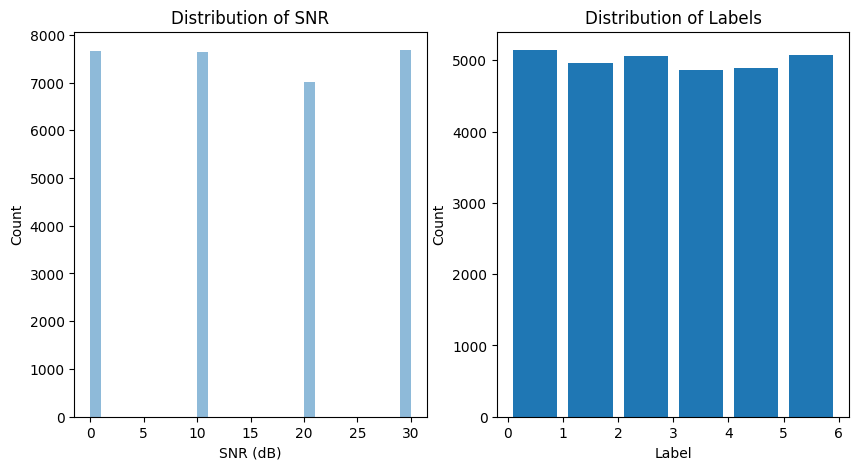

In [38]:
# Distribution des différentes classes et des différents SNR dans l'ensemble d'entrainement
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.hist(snr, bins=30, alpha=0.5)
ax1.set_title('Distribution of SNR')
ax1.set_xlabel('SNR (dB)')
ax1.set_ylabel('Count')

ax2.hist(labels_id, bins=range(7), rwidth=0.8)
ax2.set_title('Distribution of Labels')
ax2.set_xlabel('Label')
ax2.set_ylabel('Count')

plt.show()


In [39]:
count_snr_0 = np.count_nonzero(snr == 0)
count_snr_10 = np.count_nonzero(snr == 10)
count_snr_20 = np.count_nonzero(snr == 20)
count_snr_30 = np.count_nonzero(snr == 30)

print("Number of signals with SNR 0: ", count_snr_0)
print("Number of signals with SNR 10: ", count_snr_10)
print("Number of signals with SNR 20: ", count_snr_20)
print("Number of signals with SNR 30: ", count_snr_30)

Number of signals with SNR 0:  7660
Number of signals with SNR 10:  7640
Number of signals with SNR 20:  7020
Number of signals with SNR 30:  7680


In [40]:
data_path = absolute_path + 'train.hdf5'
data = h5py.File(data_path , 'r')
label_names = get_labels(data)
label_counts = np.bincount(labels_id)

for label in range(0, 6):
    label_name = label_names[label]
    print(f"Number of signals with label {label_name}: {label_counts[label]}")

data.close()

Number of signals with label N-QAM16: 5143
Number of signals with label N-PSK8: 4968
Number of signals with label N-QPSK: 5053
Number of signals with label W-QAM16: 4867
Number of signals with label W-PSK8-V1: 4894
Number of signals with label W-PSK8-V2: 5075


#### <b> Observations:</b>
On remarque que on a un nombre équilibré de signaux avec les différentes valeurs de SNR et les différents labels. Cela est encourageant dans la mesure où l'entrainement sera ainsi approprié sur le jeu de données. En effet, un dataset désequilibré nécessite des techniques plus avancées pour la classification de nos données.

----
## <b>2.3 - Visualisation de signaux</b>

### <b>2.3.a - Signal with its real and imaginary part </b>

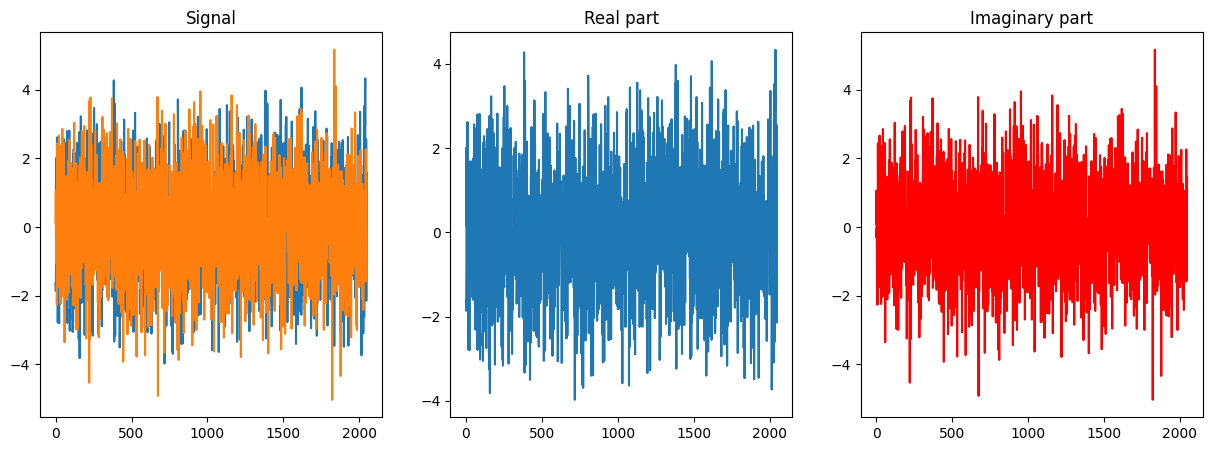

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(signals[0])
axs[0].set_title('Signal')
axs[1].plot(signals[0,:,0])
axs[1].set_title('Real part')
axs[2].plot(signals[0,:,1],color='red')
axs[2].set_title('Imaginary part')
plt.show()

### <b>2.3.b - Signal with its magnitude and argument </b>

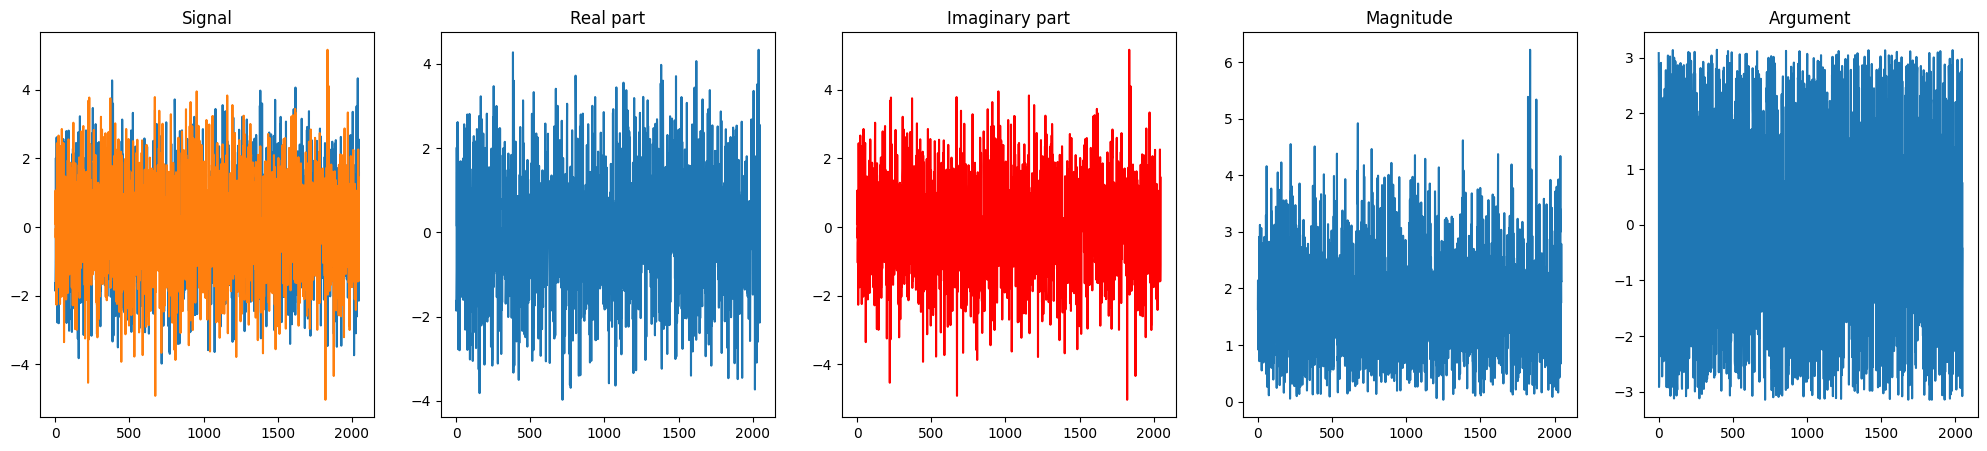

In [42]:
fig, axs = plt.subplots(1, 5, figsize=(25, 5))  # Adjusted for two additional plots

# Plot original signal, real part, and imaginary part
axs[0].plot(signals[0])
axs[0].set_title('Signal')
axs[1].plot(signals[0, :, 0])
axs[1].set_title('Real part')
axs[2].plot(signals[0, :, 1], color='red')
axs[2].set_title('Imaginary part')

magnitude = np.sqrt(signals[0, :, 0]**2 + signals[0, :, 1]**2)
argument = np.arctan2(signals[0, :, 1], signals[0, :, 0])
# Plot the magnitude and argument
axs[3].plot(magnitude)
axs[3].set_title('Magnitude')
axs[4].plot(argument)
axs[4].set_title('Argument')

plt.show()

### <b>2.3.c - Signals with different SNR values

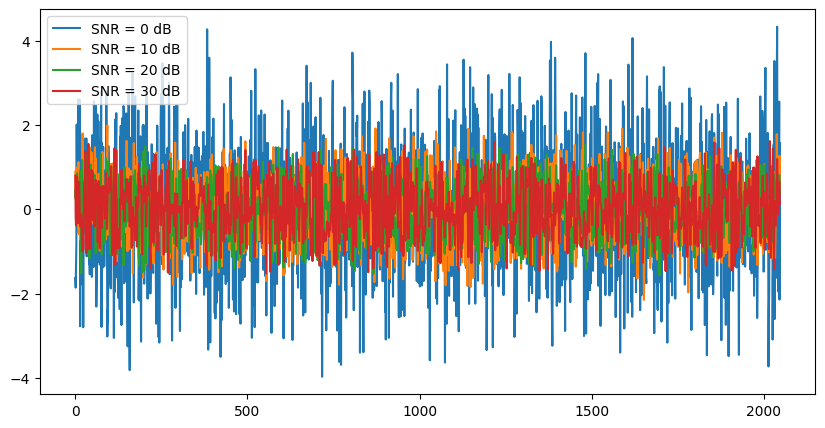

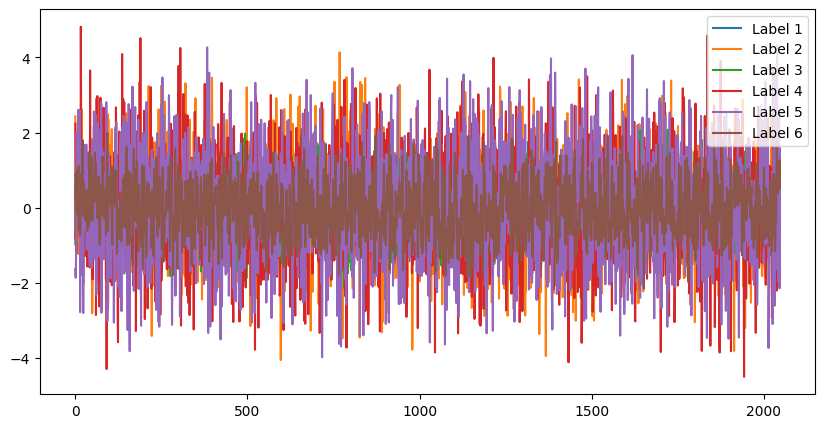

In [43]:
# Select signals with different SNR values
signals_0db = signals[snr == 0]
signals_10db = signals[snr == 10]
signals_20db = signals[snr == 20]
signals_30db = signals[snr == 30]

# Plot the signals
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(signals_0db[0,:, 0], label='SNR = 0 dB')
ax.plot(signals_10db[0,:, 0], label='SNR = 10 dB')
ax.plot(signals_20db[0,:, 0], label='SNR = 20 dB')
ax.plot(signals_30db[0,:, 0], label='SNR = 30 dB')
ax.legend()
plt.show()

# Select signals with different labels values
signals_label0 = signals[labels_id == 0]
signals_label1 = signals[labels_id == 1]
signals_label2 = signals[labels_id == 2]
signals_label3 = signals[labels_id == 3]
signals_label4 = signals[labels_id == 4]
signals_label5 = signals[labels_id == 5]

# Plot the signals
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(signals_label0[0,:, 0], label='Label 1')
ax.plot(signals_label1[0,:, 0], label='Label 2')
ax.plot(signals_label2[0,:, 0], label='Label 3')
ax.plot(signals_label3[0,:, 0], label='Label 4')
ax.plot(signals_label4[0,:, 0], label='Label 5')
ax.plot(signals_label5[0,:, 0], label='Label 6')
ax.legend()
plt.show()



#### <b> Observations:</b>
Nous observons que plus le SNR a une valeur élevée, le moins bruité le signal est. Cela correspond à la compréhension physique du signal.Nous devons alors prendre conscience que un SNR faible donnera des résultats assez mauvais pour la classification.

### <b>2.3.d - Plot the constellation signal

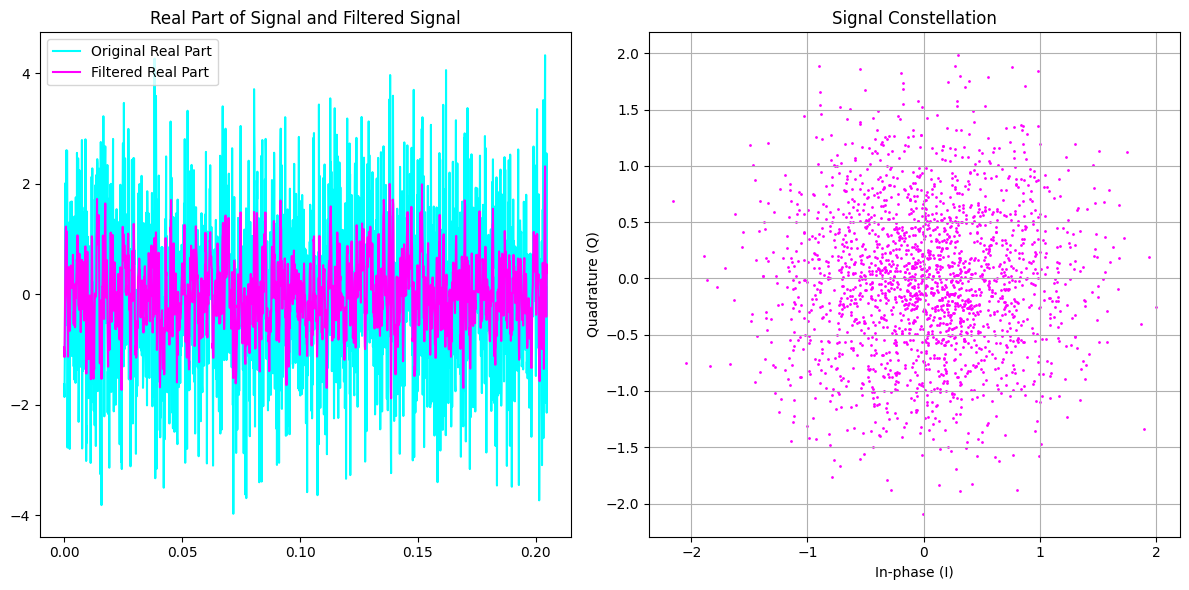

In [44]:
# Select the first signal
signal = signals[0, :, 0] + 1j * signals[0, :, 1]  # Combine into a complex signal

# Define the filter h(t) for signal shaping
h = np.ones(5) / 5.0  # A simple moving average filter

# Apply the filter to the complex signal
shaped_signal = np.convolve(signal, h, mode='same')

# Modulation parameters
f0 = 1e3  # Carrier frequency (example value)
fs = 1e4  # Sampling frequency (example value)
t = np.arange(signal.shape[0]) / fs  # Time vector based on the signal length and sampling frequency

# Modulate the shaped signal
modulated_signal = shaped_signal * np.exp(2j * np.pi * f0 * t)

# Demodulate the signal
demodulated_signal = modulated_signal * np.exp(-2j * np.pi * f0 * t)

# Sampling
sampling_period = int(fs / f0)  # Define the sampling period based on the carrier frequency
sampled_signal = demodulated_signal[::sampling_period]

# Visualization
plt.figure(figsize=(12, 6))

# Plot the real part of the original and shaped signal
plt.subplot(1, 2, 1)
plt.plot(t, signal.real, label='Original Real Part', color='cyan')
plt.plot(t, shaped_signal.real, label='Filtered Real Part', color='magenta')
plt.title('Real Part of Signal and Filtered Signal')
plt.legend()

# Plot the signal constellation (I-Q plot)
plt.subplot(1, 2, 2)
plt.scatter(modulated_signal.real, modulated_signal.imag, color='magenta', s=1)
plt.title('Signal Constellation')
plt.xlabel('In-phase (I)')
plt.ylabel('Quadrature (Q)')
plt.grid(True)

plt.tight_layout()
plt.show()


-----
-----
# <b>3 - Chargement des données en Pytorch</b>

Pour entrainer des réseaux de neurones profond sur nos données nous allons utiliser le framework Pytorch. 
Une première étape va consister à transférer les données de numpy à PyTorch, cela passe par deux objets : 
- un <b>Dataset</b> qui modélise le dataset à haut niveau dans la mémoire de l'ordinateur
- un <b>Dataloader</b> qui permet d'échantillonner le Dataset Pytorch dans les itérations de l'optimisation du réseau de neurones 
    
Un dataset prend la forme :
```python
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, path_to_data):
        ...
    def __len__(self): #retourne le nombre de données dans le dataset
        ...
    def __getitem__(self,i): #retourne pour chaque indice i un couple (data_i, label_i), data_i étant un signal et label_i le label associé au signal
        ...
```

## <b>3.1 - Implémentation Classe Dataset

In [81]:
class MyDataset(torch.utils.data.Dataset):

    def __init__(self,path_to_data):
        data = h5py.File(path_to_data, 'r')
        self.signals = np.array(data['signaux'])
        self.snr =  np.array(data['snr'])
        self.labels_id = np.array(data['labels'])
        data.close()
        self.get_snr = False

    def __len__(self):
    # retourne le nombre de données dans le dataset
        return self.signals.shape[0]
    
    def __getitem__(self,i):
        # retourne pour chaque indice i un couple (data_i, label_i)
        # data_i est un signal
        # label_i est le label associé au signal
        
        if self.get_snr:
            signal = self.signals[i]
            label = self.labels_id[i]
            snr = self.snr[i]
            return signal, label, snr
        else:
            signal = self.signals[i]
            label = self.labels_id[i]
            return signal, label

Instanciez un objet dataset et testez le sur les données samples
```python
dataset = MyDataset(...)
```

In [82]:
dataset = MyDataset(absolute_path + "train.hdf5")
dataset_valid = MyDataset(absolute_path + "validation.hdf5")

-----
## <b> 3.2 - Classe Dataloader

Pytorch propose une classe Dataloader qui permet d'échantillonner des batchs de taille fixe à partir d'un dataset. 
La cellule suivante donne un exemple d'utilisation

Testez le dataloader pour différentes valeurs de batch_size 

In [47]:
batch_size_list = [10,20,30,50,100]
for i in batch_size_list:
    dataloader = DataLoader(dataset, 
                        batch_size=i, 
                        shuffle=True
                       )
    print("Batch size = ", i)
    for j, batch in enumerate(dataloader):
        print("Batch ", j, " : ", batch[0].shape, batch[1].shape)
        if j == 0:
            break

# On retourne à la valeur initiale du dataloader
dataloader = DataLoader(dataset, 
                        batch_size=10, 
                        shuffle=True
                       )

Batch size =  10
Batch  0  :  torch.Size([10, 2048, 2]) torch.Size([10])
Batch size =  20
Batch  0  :  torch.Size([20, 2048, 2]) torch.Size([20])
Batch size =  30
Batch  0  :  torch.Size([30, 2048, 2]) torch.Size([30])
Batch size =  50
Batch  0  :  torch.Size([50, 2048, 2]) torch.Size([50])
Batch size =  100
Batch  0  :  torch.Size([100, 2048, 2]) torch.Size([100])


In [48]:
batch_size_train = 32
batch_size_test = 64 # Maximum to improove evaluation time

dataloader = DataLoader(dataset, 
                        batch_size=batch_size_train, 
                        shuffle=True
                       )

dataloader_valid = DataLoader(dataset_valid, 
                        batch_size=batch_size_test, 
                        shuffle=True
                       )

-----
-----
# <b>4 - Mise en place d'un réseau "dumb" pour tester la pipeline d'entrainement</b>

## <b>4.1 - Définition du modèle & Instanciation</b>

Définissez un premier modèle Pytorch qui prend en entrée un batch de données; tenseur de dimensions <b>[B , C, T]</b> avec: 
- B la taille du batch 
- C le nombre de canaux des signaux  
- T le nombre d'échantillons dans les signaux 

Il renvoie un batch de vecteur de probabilités (ou de log probabilités si vous préférez); tenseur de dimensions <b>[B,N]</b>:
- N est le nombre de classe à identifier 

Ce Modèle doit être très simple, il doit être rapide à exécuter, il servira à tester et éventuellement débugger la pipeline d'entrainement que vous mettrez en place un peu plus loin. Un template d'implémentation d'une classe Model se trouve dans les diapositives du cours.

In [49]:
class SimpleModel(nn.Module):
    def __init__(self,num_sample, num_channels, num_classes):
        super(SimpleModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(num_channels*num_sample, num_classes)  # T should be defined globally or passed as an argument

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

Instanciez votre modèle et testez la consistence de ses entrées / sorties vis à vis des données étudiées 

In [50]:
model_simple = SimpleModel(2048,2,6)

In [51]:
print('Dimension en entrée:')
print(next(iter(dataloader))[0].shape)
print("")
print('Dimension en sortie:')
print(model_simple(next(iter(dataloader))[0]).shape)

Dimension en entrée:
torch.Size([32, 2048, 2])

Dimension en sortie:
torch.Size([32, 6])


-----
## <b>4.2 - Mise en place de la pipeline d'entraînement</b>

La pipeline d'entrainement consiste à :
- charger les données 
- les batcher 
- réaliser des itération (epochs) de descente de gradient pour optimiser les paramètres d'un algorithme selon une fonction de perte (loss)
- logger l'évolution au fil des epochs  de la loss sur l'ensemble train et l'ensemble de validation et éventuellement de métriques complémentaires 

Mettez en place votre pipeline et testez là sur votre modèle dumb. Faites en sorte que votre façon de logger les loss et les métriques vous permette de visualiser l'évolution de ces différents indicateurs sur l'ensemble d'entrainement et de validation au fil des epochs. 

### <b>4.2.a - Accuracy loop </b>

In [52]:
def test_acc(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()
    accuracy = correct / total
    return accuracy

### <b>4.2.b - Training loop</b>

In [53]:
device = 'cuda:0' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU 

model = model_simple  # vous instanciez ici votre modèle

loss = nn.NLLLoss() # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters()) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = 5 # le nombre d'itérations dans l'entrainement 

chemin_vers_sauvegarde_model = "Save_Dumb.pt" # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard. 

model.to(device) # on place le modèle dans le GPU si nécessaire

loss_hist = []
loss_train_hist = []
loss_valid_hist = []
acc_train_hist = []
acc_valid_hist = []

P = ProgressTrain(len(dataloader),num_update=len(dataloader))

for epoch in range(n_epochs):
    
    model.train()  # Set the model to training mode
    
    for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        l = loss(batch_y_predicted, batch_y.long())
        l.backward()
        optimizer.step()

        loss_hist.append(l.item())

        P.Update([l.item()])

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_loss_valid = 0
        for batch_x, batch_y in dataloader_valid:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_y_predicted = model(batch_x)
            l_val = loss(batch_y_predicted, batch_y.long())
            total_loss_valid += l_val.item()
    
    mean_loss_train = np.sum(np.array(loss_hist)[-len(dataloader):])/len(dataset)
    mean_loss_valid = 2*total_loss_valid/len(dataset_valid)

    acc_train = 100*test_acc(model, dataloader)
    acc_valid = 100*test_acc(model, dataloader_valid)

    P.End([mean_loss_train,mean_loss_valid,acc_train,acc_valid])

    loss_train_hist.append(mean_loss_train)
    loss_valid_hist.append(mean_loss_valid)

    acc_train_hist.append(acc_train)
    acc_valid_hist.append(acc_valid)

torch.save(model, chemin_vers_sauvegarde_model)

[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||


----
## <b>4.3 - Evaluation metrics

### <b>4.3.a - Loss and Accuracy

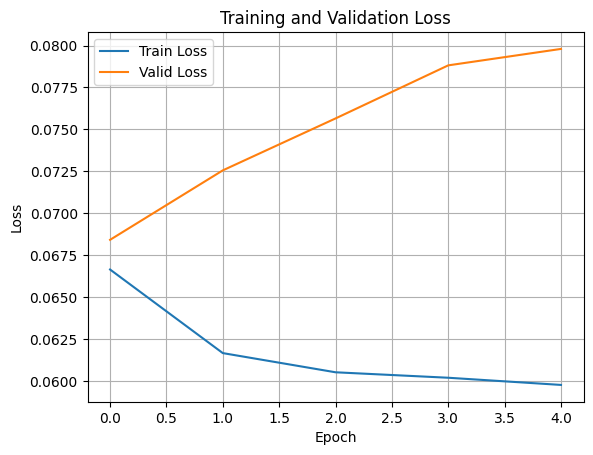

In [54]:
plt.plot(loss_train_hist, label='Train Loss')
plt.plot(loss_valid_hist, label='Valid Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.show()

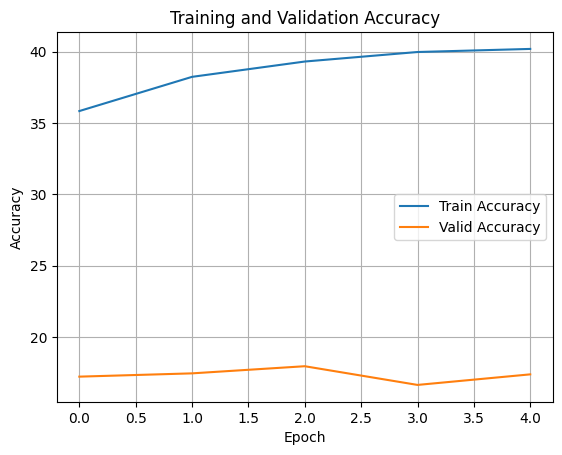

In [55]:
plt.plot(acc_train_hist, label='Train Accuracy')
plt.plot(acc_valid_hist, label='Valid Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.show()

#### <b> Observations </b>
On observe que l'accuracy est très faible pour la validation (cela correspond à une classification aléaoire, 100/6 ~ 17 ). Il faut donc passer à une classification plus évoluée avec des réseaux de neurones.

-----
-----
# <b>5 - Entraînement de réseaux de neurones</b>

Dans cette partie vous définissez une ou plusieurs architecture de réseaux de neurones profonds et vous les réglez sur les données d'entrainement. 
Vous pouvez notamment utiliser des réseaux à base de convolutions et/ou de couches réurrentes. 

Vous pouvez vous inspirer de ce qui a été dit en cours sur la reconnaissance vocale.

Vous pouvez si vous le souhaitez mettre en place des stratégies d'augmentation de données pour améliorer vos résultats. Pour mettre l'augmentation de données en pratique pouvez vous renseigner sur l'argument collate_fn du dataloader standard de Pytorch. 

## <b> 5.1 - Définition architectures de réseaux de neurones profonds

### <b> 5.1.a - Architecture Initiale (Model n°1) </b>

In [56]:
class HighReceptiveFieldModel(nn.Module):
    def __init__(self, num_channels=2, num_classes=6):
        super(HighReceptiveFieldModel, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=3, stride=1, padding=2, dilation=2) #(B,32,T)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=2, dilation=2)           #(B,64,T//2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=2, dilation=2)          #(B,128,T//4)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)
        
                                                                                                #(B,128,T//8)

        # LSTM layer
        self.lstm = nn.LSTM(input_size=128, hidden_size=128, num_layers=1, batch_first=True)    #(B,128,T//8)
        # Fully connected layer
        self.fc = nn.Linear(128, num_classes)                                                   #(B,128) --) (B,6)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        # LSTM layer
        x = x.transpose(1, 2)  # Reshape for LSTM
        x, (hn, cn) = self.lstm(x)

        # Classifier
        x = self.fc(x.mean(dim=1)) 
        return F.log_softmax(x, dim=1)

Cette architecture est de bonne qualité :

1. **Indépendance par rapport à la taille du temps d'entrée** : L'utilisation de conv, de couches de mise en commun et de LSTM permet au modèle de traiter des séquences d'entrée de longueur variable. 

2. **Champ réceptif** : L'architecture augmente le champ réceptif grâce à l'utilisation de convolutions dilatées (dilatation=2) et de rembourrages.

3. **Couche LSTM** : La LSTM est capable de saisir les dépendances à long terme dans les données séquentielles. La moyenne sur la dernière couche permet une bonne remontée du gradient et une bonne prise en compte de l'ensemble du signal.

Cette architecture est le résultat de nos expérimentations (bon résultat avec du maxpooling, les dilated convolutions et la moyenne en sortie d'un LSTM)

In [57]:
total_params = 0
for name, param in HighReceptiveFieldModel().named_parameters():
    num_params = param.numel()
    total_params += num_params
    print(f"{name:<30} | Number of Parameters: {num_params}")

# Print total parameters in bold
print(f"\033[1mTotal Number of Parameters: {total_params}\033[0m")


conv1.weight                   | Number of Parameters: 192
conv1.bias                     | Number of Parameters: 32
bn1.weight                     | Number of Parameters: 32
bn1.bias                       | Number of Parameters: 32
conv2.weight                   | Number of Parameters: 6144
conv2.bias                     | Number of Parameters: 64
bn2.weight                     | Number of Parameters: 64
bn2.bias                       | Number of Parameters: 64
conv3.weight                   | Number of Parameters: 24576
conv3.bias                     | Number of Parameters: 128
bn3.weight                     | Number of Parameters: 128
bn3.bias                       | Number of Parameters: 128
lstm.weight_ih_l0              | Number of Parameters: 65536
lstm.weight_hh_l0              | Number of Parameters: 65536
lstm.bias_ih_l0                | Number of Parameters: 512
lstm.bias_hh_l0                | Number of Parameters: 512
fc.weight                      | Number of Parameters: 

### <b> 5.2.b - Architecture finale (Model n°2)

In [58]:
class BestModel(nn.Module):
    def __init__(self, num_channels=2, num_classes=6):
        super(BestModel, self).__init__()
        self.conv1 = nn.Conv1d(num_channels, 32, kernel_size=3, stride=1, padding=2, dilation=1)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)  # Max pooling layer
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=2, dilation=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)  # Max pooling layer
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=2, dilation=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)  # Max pooling layer
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=2, dilation=2)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(2)  # Max pooling layer
        self.conv5 = nn.Conv1d(256, 400, kernel_size=3, stride=1, padding=2, dilation=2)
        self.bn5 = nn.BatchNorm1d(400)
        self.pool5 = nn.MaxPool1d(2)  # Max pooling layer

        # LSTM layer
        self.lstm = nn.LSTM(input_size=400, hidden_size=200, num_layers=1, batch_first=True, bidirectional=True)
        # Fully connected layer
        self.fc = nn.Linear(200 * 2, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))
        x = self.pool5(F.relu(self.bn5(self.conv5(x))))

        # LSTM layer
        x = x.transpose(1, 2)  # Reshape for LSTM
        x, (hn, cn) = self.lstm(x)

        # Classifier
        x = self.fc(x.mean(dim=1)) 
        return F.log_softmax(x, dim=1)

Ce modèle est similaire à celui ci-dessus, mais avec plus de paramètres et a donné de meilleurs résultats.

In [59]:
total_params = 0
for name, param in BestModel().named_parameters():
    num_params = param.numel()
    total_params += num_params
    print(f"{name:<30} | Number of Parameters: {num_params}")

# Print total parameters in bold
print(f"\033[1mTotal Number of Parameters: {total_params}\033[0m")

conv1.weight                   | Number of Parameters: 192
conv1.bias                     | Number of Parameters: 32
bn1.weight                     | Number of Parameters: 32
bn1.bias                       | Number of Parameters: 32
conv2.weight                   | Number of Parameters: 6144
conv2.bias                     | Number of Parameters: 64
bn2.weight                     | Number of Parameters: 64
bn2.bias                       | Number of Parameters: 64
conv3.weight                   | Number of Parameters: 24576
conv3.bias                     | Number of Parameters: 128
bn3.weight                     | Number of Parameters: 128
bn3.bias                       | Number of Parameters: 128
conv4.weight                   | Number of Parameters: 98304
conv4.bias                     | Number of Parameters: 256
bn4.weight                     | Number of Parameters: 256
bn4.bias                       | Number of Parameters: 256
conv5.weight                   | Number of Parameters: 30

-----
## <b> 5.2 - Training and Evaluation Loop

### <b> Early Stopping function definition

In [60]:
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_accuracy):
        score = val_accuracy

        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

### <b> 5.2.a - Training and evaluation Model n°1

In [63]:
device = 'cuda:0' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU 

model = HighReceptiveFieldModel() # vous instanciez ici votre modèle

loss = nn.NLLLoss() # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters(),lr = 0.003) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = 50 # le nombre d'itérations dans l'entrainement 

early_stopping = EarlyStopping(patience=5)

chemin_vers_sauvegarde_model = "Model_Small_LSTM" # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard. 

model.to(device) # on place le modèle dans le GPU si nécessaire


loss_hist_m1 = []
loss_valid_hist_m1 = []
loss_train_hist_m1 = []

acc_train_hist_m1 = []
acc_valid_hist_m1 = []

P = ProgressTrain(len(dataloader),num_update=len(dataloader))

for epoch in range(n_epochs):

    model.train()  # Set the model to training mode

    for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
        
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        if epoch<-42: # Test d'apprentisage des class difficiles à classifier dès le début
            mask = (batch_y == 2) | (batch_y == 3)
            modified_target = batch_y.clone()
            modified_target[~mask] = 1
            l = loss(batch_y_predicted, modified_target.long())
        else:
            l = loss(batch_y_predicted, batch_y.long())
        l.backward()
        optimizer.step()

        # Log training loss
        loss_hist_m1.append(l.item())

        P.Update([l.item()])
    
        

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_loss_valid = 0
        for batch_x, batch_y in dataloader_valid:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_y_predicted = model(batch_x)
            l_val = loss(batch_y_predicted, batch_y.long())
            total_loss_valid += l_val.item()


    mean_loss_train = np.sum(np.array(loss_hist_m1)[-len(dataloader):])/len(dataset)
    mean_loss_valid = 2*total_loss_valid/len(dataset_valid)

    acc_train = 100*test_acc(model, dataloader)
    acc_valid = 100*test_acc(model, dataloader_valid)

    P.End([mean_loss_train,mean_loss_valid,acc_train,acc_valid])
    print([mean_loss_train,mean_loss_valid,acc_train,acc_valid])

    loss_train_hist_m1.append(mean_loss_train)
    loss_valid_hist_m1.append(mean_loss_valid)

    acc_train_hist_m1.append(acc_train)
    acc_valid_hist_m1.append(acc_valid)

    early_stopping(acc_valid)
    
    if early_stopping.best_score == acc_valid:
        torch.save(model, chemin_vers_sauvegarde_model+".pt")
    
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.030397742289304735, 0.020641350293159486, 58.76, 58.68]
[0.021950763116280237, 0.02265899006128311, 56.32, 56.08]
[0.020164560709396998, 0.01763199891448021, 66.46333333333332, 66.78]
[0.01791058688759804, 0.015904447835683823, 69.33333333333334, 69.28999999999999]
[0.016983145340283713, 0.016331629997491836, 67.86, 67.51]
[0.016172059625387192, 0.015087789207696914, 69.95333333333333, 70.33]
[0.01565254825949669, 0.014961128968000411, 70.53, 70.72]
[0.015142267453670501, 0.013917043656110763, 75.22999999999999, 75.44999999999999]
[0.013098570023477078, 0.0102811566978693, 82.34, 81.99]
[0.011268301018575828, 0.009853509971499443, 82.89999999999999, 83.04]
[0.010650815661003192, 0.0111224505007267, 81.15, 81.38]
[0.01041956017886599, 0.013295325174927711, 79.97999999999999, 80.08]
[0.010186613989124696, 0.009508265326917172, 82.49, 83.08]
[0.010855301129072905, 0

### <b>5.2.b - Training and Evaluation Model n°2

In [64]:
device = 'cuda:0' # set so 'cuda:xx' if you have a GPU, xx is GPU index. L'entraînement des réseaux de neurones est grandement accéléré par l'utilisation d'un GPU 

model = BestModel() # vous instanciez ici votre modèle

loss = nn.NLLLoss() # définissez la fonction de perte selon laquelle le modèle sera optimisé

optimizer = torch.optim.Adam(model.parameters(),lr = 0.003) # en pratique on utilise pas une simple descente de gradient mais une procédure d'optimisation plus sophistiquée qui est implémentée sous la forme d'un objet Optimizer. Il en existe beaucoup d'optimizers différents, vous pouvez en tester différents, je vous propose d'utiliser en premier lieu l'algorithme Adam

n_epochs = 50 # le nombre d'itérations dans l'entrainement 

early_stopping = EarlyStopping(patience=5)

chemin_vers_sauvegarde_model = "Model_Big_LSTM" # chemin vers un fichier où vous sauvegarderez votre modèle après optimisation pour le réutiliser plus tard. 

model.to(device) # on place le modèle dans le GPU si nécessaire


loss_hist = []
loss_valid_hist = []
loss_train_hist = []

acc_train_hist = []
acc_valid_hist = []

P = ProgressTrain(len(dataloader),num_update=len(dataloader))

for epoch in range(n_epochs):

    model.train()  # Set the model to training mode

    for batch_idx, (batch_x, batch_y) in enumerate(dataloader):

        
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()

        batch_y_predicted = model(batch_x)
        if epoch<-42: # Test d'apprentisage des class difficiles à classifier dès le début
            mask = (batch_y == 2) | (batch_y == 3)
            modified_target = batch_y.clone()
            modified_target[~mask] = 1
            l = loss(batch_y_predicted, modified_target.long())
        else:
            l = loss(batch_y_predicted, batch_y.long())
        l.backward()
        optimizer.step()

        # Log training loss
        loss_hist.append(l.item())

        P.Update([l.item()])
    
        

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        total_loss_valid = 0
        for batch_x, batch_y in dataloader_valid:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            batch_y_predicted = model(batch_x)
            l_val = loss(batch_y_predicted, batch_y.long())
            total_loss_valid += l_val.item()


    mean_loss_train = np.sum(np.array(loss_hist)[-len(dataloader):])/len(dataset)
    mean_loss_valid = 2*total_loss_valid/len(dataset_valid)

    acc_train = 100*test_acc(model, dataloader)
    acc_valid = 100*test_acc(model, dataloader_valid)

    P.End([mean_loss_train,mean_loss_valid,acc_train,acc_valid])
    print([mean_loss_train,mean_loss_valid,acc_train,acc_valid])

    loss_train_hist.append(mean_loss_train)
    loss_valid_hist.append(mean_loss_valid)

    acc_train_hist.append(acc_train)
    acc_valid_hist.append(acc_valid)

    torch.save(model, chemin_vers_sauvegarde_model+str(acc_valid)[:4]+".pt")
    
    early_stopping(acc_valid)
    
    if early_stopping.best_score == acc_valid:
        torch.save(model, chemin_vers_sauvegarde_model+".pt")
    
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.024299908820788065, 0.020226730549335478, 60.25666666666667, 60.809999999999995]


[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.018996043686072033, 0.020135446459054948, 63.62, 62.35000000000001]


[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.016473654852310816, 0.017562721848487853, 69.54, 69.37]


[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.014804687317212423, 0.01195179098546505, 80.03333333333333, 80.83]


[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.011106128218521675, 0.010630284687876702, 81.23333333333333, 82.24000000000001]


[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.009942504608382781, 0.009835079595446586, 82.99666666666667, 83.34]


[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.009655805736283461, 0.00977543304860592, 83.65666666666667, 83.81]


[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.009171804915616909, 0.008180815069377421, 85.76333333333334, 85.87]


[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.009034656845281522, 0.009333404994010926, 84.07, 84.69]


[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.008885167904446522, 0.008623566789925098, 85.29333333333334, 85.42999999999999]


[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.008732560620208581, 0.01063792737722397, 82.63666666666667, 83.12]


[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.008609875054409107, 0.009405368754267692, 84.55333333333334, 85.00999999999999]


[--------------------------------------------------] 0.0%    

||    ||          Loss          ||        Accuracy        ||
||    ||   Train   ||   Test    ||   Train   ||   Test    ||
[0.008461678191026051, 0.008951954257488251, 85.21, 84.65]
Early stopping triggered


-----
-----
# <b> 6 - Synthèse de résultats </b> 

Une fois que votre ou vos réseaux sont entrainez vous comparez leurs performances selon les métriques définies en introduction sur l'ensemble de test

## <b> 6.1 - Plot loss and accuracy of the model 1 :  </b>

### <b>6.1.a - Loss of the model</b>

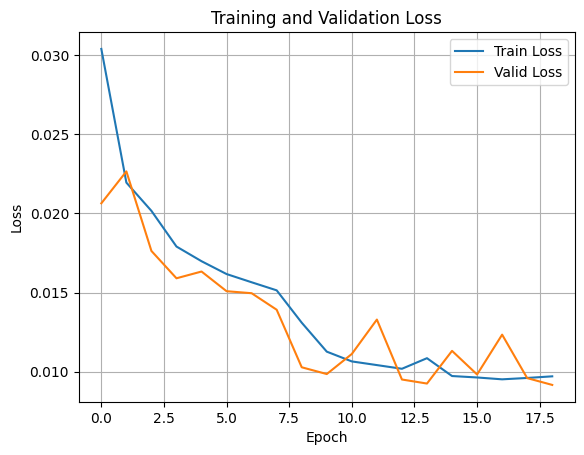

In [65]:
plt.plot(loss_train_hist_m1, label='Train Loss')
plt.plot(loss_valid_hist_m1, label='Valid Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.show()

### <b>6.1.b - Accuracy of the model

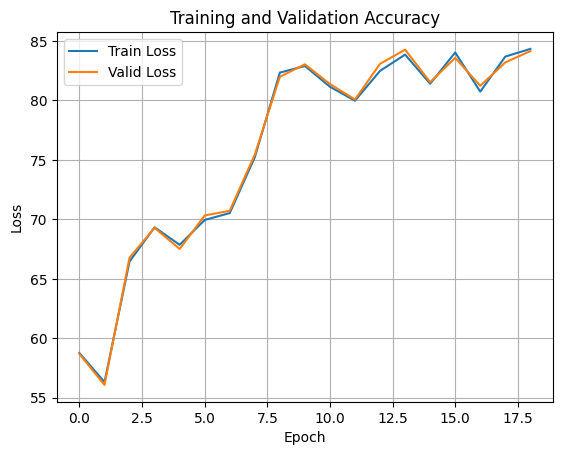

In [66]:
plt.plot(acc_train_hist_m1, label='Train Loss')
plt.plot(acc_valid_hist_m1, label='Valid Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.show()

In [68]:
model = torch.load("Model_Small_LSTM.pt")
acc_train = test_acc(model, dataloader)
acc_valid = test_acc(model, dataloader_valid)

print("Model Train Accuracy",round(100*acc_train,1),"%")
print("Model Valid Accuracy",round(100*acc_valid,1),"%")

Model Train Accuracy 83.9 %
Model Valid Accuracy 84.3 %


----
## <b>6.2 - Plot loss and accuracy of model 2 (best one) :

### <b>6.2.a - Loss of the model

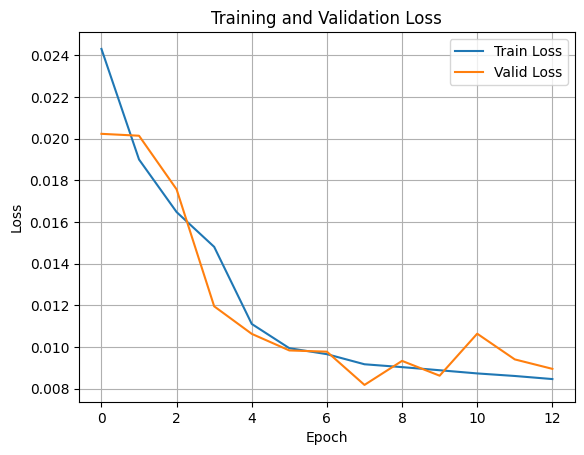

In [69]:
plt.plot(loss_train_hist, label='Train Loss')
plt.plot(loss_valid_hist, label='Valid Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.show()

### <b> 6.2.b - Accuracy of the model

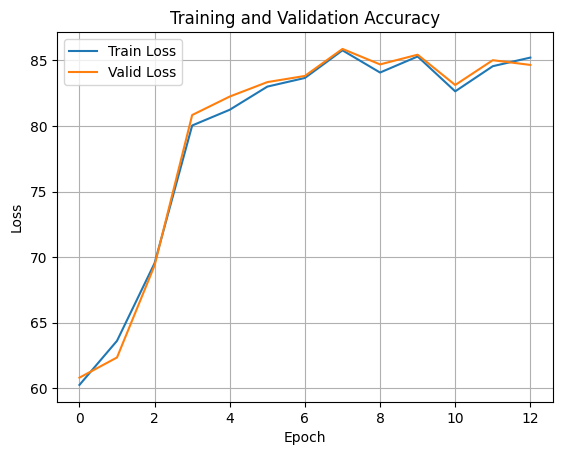

In [70]:
plt.plot(acc_train_hist, label='Train Loss')
plt.plot(acc_valid_hist, label='Valid Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.show()

In [72]:
model = torch.load("Model_Big_LSTM.pt")
acc_train = test_acc(model, dataloader)
acc_valid = test_acc(model, dataloader_valid)

print("Model Train Accuracy",round(100*acc_train,1),"%")
print("Model Valid Accuracy",round(100*acc_valid,1),"%")

Model Train Accuracy 85.8 %
Model Valid Accuracy 85.9 %


#### <b> Observations:</b>
On observe que le modèle numéro 2 a une accuracy plus élevée que le modèle numéro 1. 
Néanmoins, pour les deux on a une loss qui tend vers 0 et une accuracy qui augmente, ce qui est positif.

----
## <b> 6.3 - Plot Confusion Matrix of model 1:

### <b> 6.3.a - Confusion Matrix for all the signals

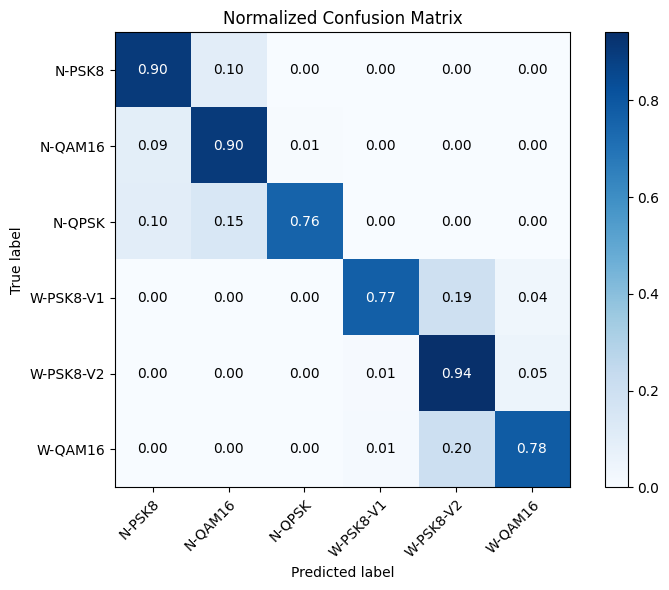

In [91]:
model = torch.load("Model_Small_LSTM.pt")
data = h5py.File(data_path , 'r')
class_names = list(get_labels(data).values())
data.close()
    
def plot_confusion_matrix(model, dataloader, class_names):
    
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for data in dataloader:
            inputs, labels = data
            outputs = model(inputs.to(device))

            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm_normalized.shape[1]),
           yticks=np.arange(cm_normalized.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_names, yticklabels=class_names,
           title='Normalized Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for i in range(cm_normalized.shape[0]):
        for j in range(cm_normalized.shape[1]):
            ax.text(j, i, format(cm_normalized[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()


plot_confusion_matrix(model, dataloader_valid, class_names)

### <b> 6.3.b - Confusion Matrix classified by SNR values

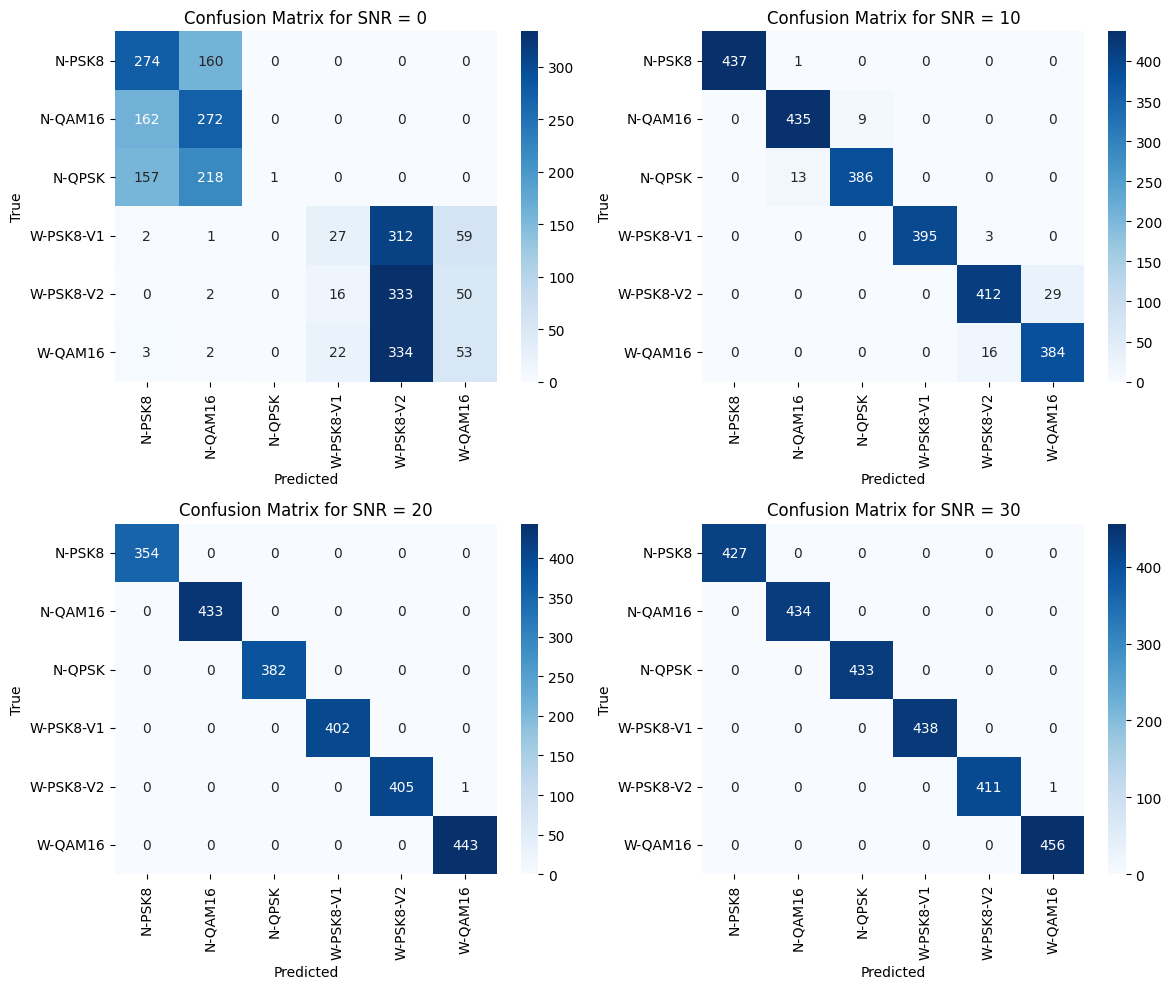

In [92]:
def plot_confusion_matrix_snr(model, dataset, class_names):
    
    model.eval()  # Set the model to evaluation mode
    
    y_true = []
    y_pred = []
    snr_true = []
    
    dataset.get_snr = True
    with torch.no_grad():  # Disable gradient calculation for efficiency
        for i in range(len(dataset)):
            
            
            inputs, labels, snr = dataset[i]
            outputs = model(torch.tensor(inputs).to(device).unsqueeze(0))

            _, predicted = torch.max(outputs.data, 1)
            
            
            y_true.append(labels)
            y_pred.append(predicted[0].item())
            snr_true.append(snr)
            
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    snr_true = np.array(snr_true)
    
    dataset.get_snr = False
    unique_snr_values = [0, 10, 20, 30]

    # Set up subplot grid
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    # Plot confusion matrix for each SNR value
    for i, snr_value in enumerate(unique_snr_values):
        mask = snr_true == snr_value
        y_true_snr = y_true[mask]
        y_pred_snr = y_pred[mask]

        cm = confusion_matrix(y_true_snr, y_pred_snr)
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, ax=axes[i],cmap='Blues')
        axes[i].set_title(f'Confusion Matrix for SNR = {snr_value}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('True')

    plt.tight_layout()
    plt.show()

plot_confusion_matrix_snr(model, dataset_valid, class_names)

----
## <b> 6.4 - Plot Confusion Matrix of model 2 (best one):

### <b> 6.4.1 - Confusion Matrix for all the signals

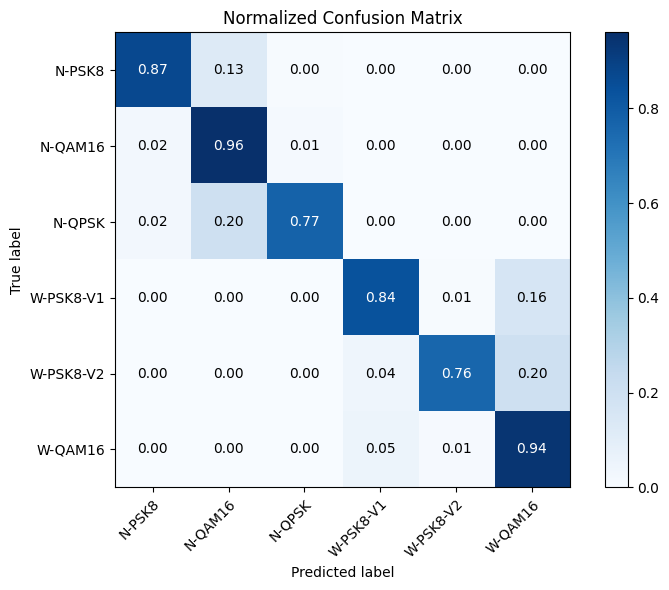

In [93]:
model = torch.load("Model_Big_LSTM.pt")

plot_confusion_matrix(model, dataloader_valid, class_names)

### <b> 6.4.2 - Confusion Matrix classified by SNR values

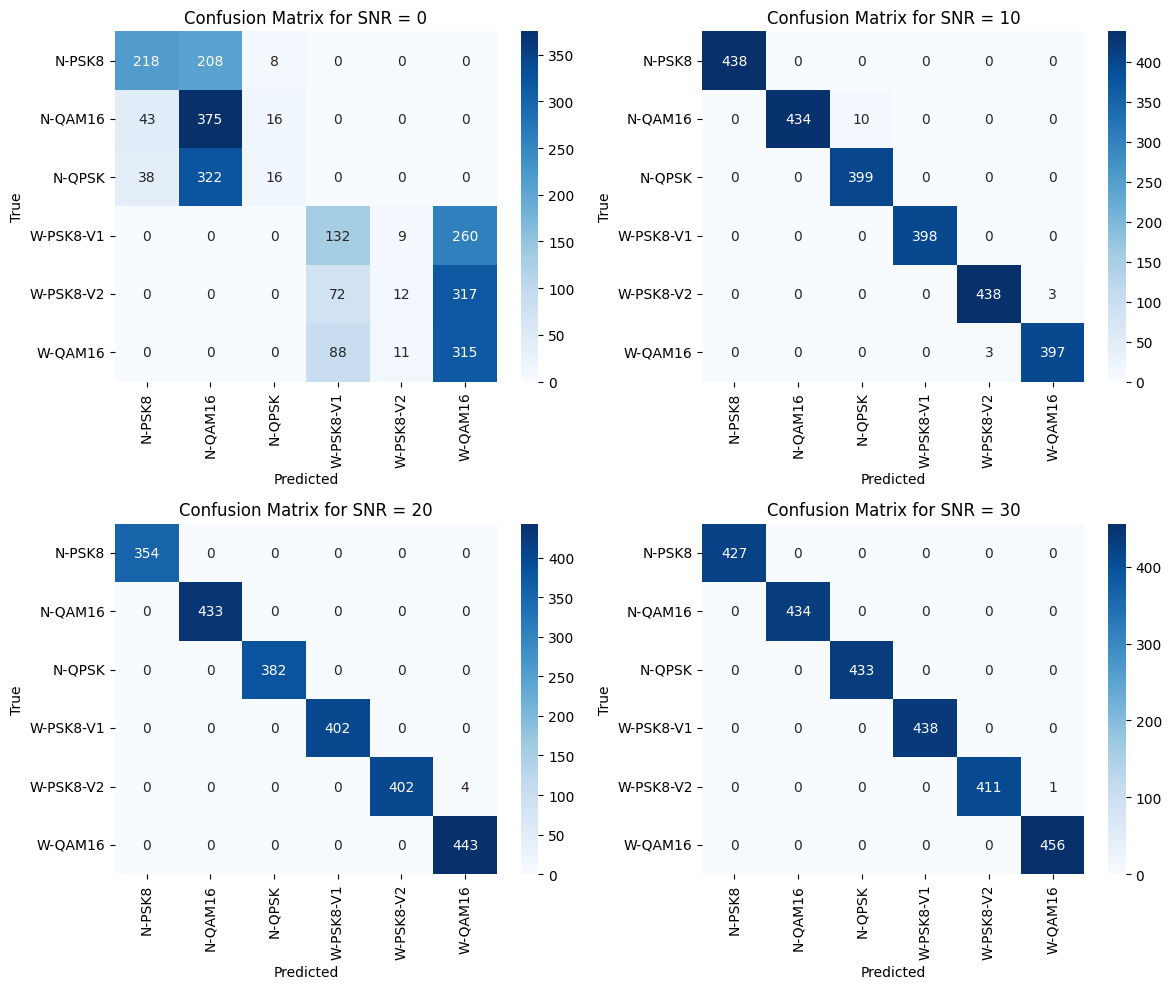

In [94]:
plot_confusion_matrix_snr(model, dataset_valid, class_names)

----
----
# <b>Conclusion

La conclusion de ce travail pratique révèle clairement que la qualité de la classification est fortement compromise lorsque le rapport signal sur bruit (SNR) est bas. Cette dégradation se manifeste de manière évidente dans les matrices de confusion. En particulier, un SNR de 10 semble être un seuil critique affectant la performance du modèle, le rendant difficile à optimiser au-delà de 85 % de précision. Pour améliorer davantage la performance, une stratégie envisageable serait d'éliminer les signaux présentant un SNR trop faible. Cette approche, qui consisterait à supprimer les signaux excessivement bruyants, pourrait potentiellement augmenter la précision du modèle. Cette méthode mérite d'être explorée pour évaluer son impact sur l'efficacité globale de la classification.